In [ ]:
# TODO FIX explosion rapide des valeurs
# TODO unification du calcul des kernels + des valeurs

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [2]:
with open("first_database.pkl", "rb")as f:
    X,y=pickle.load(f)

In [3]:
# parameters
n = 100
m = 10
a = 5 # nb of agents
sigma = 0.5
nu = 1.0

In [4]:
sel = list(range(n))
ind = np.random.choice(sel,m,replace=False)
x_selected = X[ind] # ids_M
ind

array([19, 36,  1, 68, 48, 94, 65, 76, 51, 74])

In [5]:
from kernel import kernel_matrix
Kmm = kernel_matrix(X, ind, ind)
Knm = kernel_matrix(X, sel, ind)

In [6]:
sel_copy = np.arange(n)
np.random.shuffle(sel_copy)
agents = np.array_split(sel_copy, a)

In [7]:
agents

[array([55, 25, 58,  5, 82, 51,  7, 44, 24, 20, 16,  3, 96, 60, 95, 94, 90,
        56, 40, 10]),
 array([69, 33, 18, 17,  4, 36, 45, 28, 42, 39, 31, 97, 19, 35, 57, 23, 67,
        11,  1, 71]),
 array([53, 81, 47, 91, 85, 87, 32, 27, 30, 12, 41, 46, 79,  6, 62, 86, 48,
        73, 64, 75]),
 array([78, 43, 37, 52, 21, 88, 92, 70, 72, 84, 13, 61, 26, 59, 74, 77, 29,
        34, 14, 54]),
 array([ 8, 76, 22,  9, 68, 15,  0, 93, 89, 99, 65, 98, 49, 83, 80, 38, 66,
         2, 63, 50])]

In [8]:
def grad_fi(dataY, Kmm, Knm, alpha, ids_agent):
    Kim = Knm[ids_agent, :]
    return sigma**2/5*Kmm@alpha + Kim.T@(Kim@alpha - dataY[ids_agent]) + nu/5*alpha 

In [11]:
import networkx as nx
from graph_tools import metropolis_weight_matrix, laplacian_weight_matrix
# from kernel import grad_fi

step_size = 0.002 # placeholder
step_count = 1000 # placeholder

G = nx.cycle_graph(a)
W = laplacian_weight_matrix(G, 0.1) # check the matrices
xi = np.random.normal(0, 0.01, size=(step_count+1, a, m))
g = np.zeros((step_count+1, a, m))
# local gradients
for i, id_agent in enumerate(agents):
    g[0, i, :] = grad_fi(y, Kmm, Knm, xi[0,i,:], id_agent)

for k in range(step_count):
    xi[k+1, :, :] = W@xi[k, :, :] - step_size*g[k, :, :] # note that W is symetric so W.T doesn't matter
    g[k+1, :, :] = W@g[k,:,:]
    for i, id_agent in enumerate(agents):
        g[k+1, i, :] += \
            + grad_fi(y, Kmm, Knm, xi[k+1,i, :], id_agent) \
            - grad_fi(y, Kmm, Knm, xi[k,i,:], id_agent)


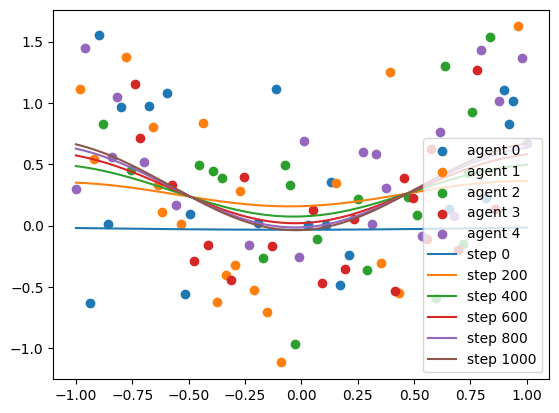

In [12]:
# plt.scatter(x[sel], y[sel])
for i in range(a):
    plt.scatter(X[agents[i]], y[agents[i]], label="agent %d"%(i))

from kernel import calc_f
nt = 250
x_linspace = np.linspace(-1, 1, nt)
for s in range(0, step_count+1, step_count // 5):
    pred = [calc_f(X, ind, v, xi[s, 0, :]) for v in x_linspace]
    plt.plot(x_linspace, pred, label="step %d" % s)

plt.legend()
plt.show()